# Author:
- Name: Quan Hoang Ngoc
- ID: 22521178
- Time: 28/10/2024
- Lab1

In [ ]:
import os
import sys
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.5.0+cu121
False
0


## Content

## Clone corpus

In [ ]:
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
torch_ds = datasets.Caltech101(root='./data', download=True)
torch_ds, torch_ds[0], torch_ds[10]

Files already downloaded and verified


(Dataset Caltech101
     Number of datapoints: 8677
     Root location: ./data/caltech101
     Target type: ['category'],
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=510x337>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=479x316>, 0))

## Valid dataset

In [ ]:
from imutils import paths
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
image_paths = list(paths.list_images('./data/caltech101'))
data = []
labels = []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Color to gray
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    size = img.shape[0]*img.shape[1]
    hist = hist/size
    hist = hist.flatten()
    data.append(hist)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)
data.shape, labels.shape

100%|██████████| 9144/9144 [00:18<00:00, 499.32it/s]


((8677, 256), (8677,))

In [ ]:
classes = sorted(np.unique(labels))
label_mapping = {label: idx for idx, label in enumerate(classes)}
encoded = np.array([label_mapping[label] for label in labels])
encoded

array([ 5,  5,  5, ..., 65, 65, 65])

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, encoded, test_size=0.2, random_state=42)

# Further split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5205, 256)
y_train shape: (5205,)
X_val shape: (1736, 256)
y_val shape: (1736,)
X_test shape: (1736, 256)
y_test shape: (1736,)


## Task1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = [1, 2, 3, 4, 5]
results = []

for k in k_values:
    # Create and train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on validation and test sets
    y_pred_val = knn.predict(X_val)
    y_pred_test = knn.predict(X_test)

    # Calculate accuracy scores
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append([k, acc_val, acc_test])

# Print the results in a table format
print("k\tAcc val\tAcc test")
for row in results:
    print("{}\t{:.4f}\t{:.4f}".format(row[0], row[1], row[2]))

k	Acc val	Acc test
1	0.2195	0.2241
2	0.2298	0.2339
3	0.2339	0.2460
4	0.2379	0.2385
5	0.2408	0.2437


## Task2

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score
import pandas as pd
from tabulate import tabulate

# Create and train the SVC classifier
svc = SVC(C=1)
svc.fit(X_train, y_train)

# Predict on the test set
y_pred_test = svc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set:", f"{accuracy:.4f}")

# Calculate precision for each class
precision_per_class = precision_score(y_test, y_pred_test, average=None)


# Create a list of lists for the table data
table_data = [[label, f"{precision:.4f}"] for label, precision in zip(classes, precision_per_class)]
# Print the table using tabulate
print(tabulate(table_data, headers=["Class", "Precision"], tablefmt="grid"))

# for label, precision in zip(classes, precision_per_class):
#     print(f"{label}: {precision:.4f}")

Accuracy on test set: 0.2512
+-----------------+-------------+
| Class           |   Precision |
+=================+=============+
| Faces           |      0.0753 |
+-----------------+-------------+
| Faces_easy      |      0.1479 |
+-----------------+-------------+
| Leopards        |      0.3043 |
+-----------------+-------------+
| Motorbikes      |      0.4186 |
+-----------------+-------------+
| accordion       |      0      |
+-----------------+-------------+
| airplanes       |      0.5276 |
+-----------------+-------------+
| anchor          |      0      |
+-----------------+-------------+
| ant             |      0      |
+-----------------+-------------+
| barrel          |      0      |
+-----------------+-------------+
| bass            |      0      |
+-----------------+-------------+
| beaver          |      0      |
+-----------------+-------------+
| binocular       |      0.3333 |
+-----------------+-------------+
| bonsai          |      0      |
+-----------------+

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Task3

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

def svc_task(strategy):
    # Create and train the SVC classifier with one-vs-one strategy
    svc = SVC(C=1, decision_function_shape=strategy)  # ovo for one-vs-one
    svc.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = svc.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy on test set:", f"{accuracy:.4f}")

    # Calculate the number of support vectors
    n_support_vectors = sum(svc.n_support_)
    print("Number of support vectors:", n_support_vectors)
    n_support_vectors = svc.support_vectors_.shape[0]
    print("Number of support vectors:", n_support_vectors)

    # Calculate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print("Confusion matrix:\n", cm)

    # Optionally, display the confusion matrix as a heatmap (requires seaborn and matplotlib)
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=False, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy on test set: 0.2512
Number of support vectors: 4811
Number of support vectors: 4811
Confusion matrix:
 [[28 42  0 ...  0  0  0]
 [20 59  0 ...  0  0  0]
 [ 8  4 28 ...  0  0  0]
 ...
 [ 3  2  0 ...  0  0  0]
 [ 0  2  0 ...  0  1  0]
 [ 1  1  0 ...  0  0  6]]


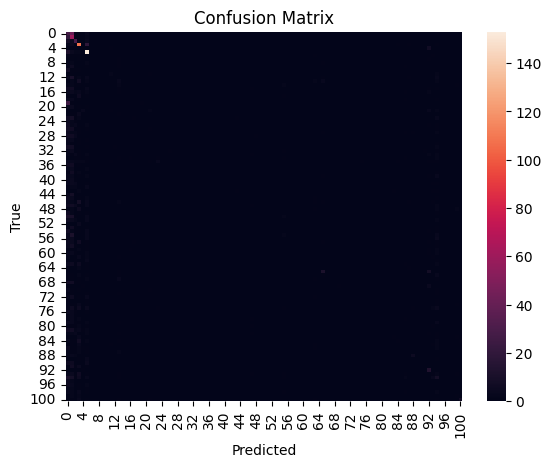

In [ ]:
svc_task('ovo')

## Task4

Accuracy on test set: 0.2512
Number of support vectors: 4811
Number of support vectors: 4811
Confusion matrix:
 [[28 42  0 ...  0  0  0]
 [20 59  0 ...  0  0  0]
 [ 8  4 28 ...  0  0  0]
 ...
 [ 3  2  0 ...  0  0  0]
 [ 0  2  0 ...  0  1  0]
 [ 1  1  0 ...  0  0  6]]


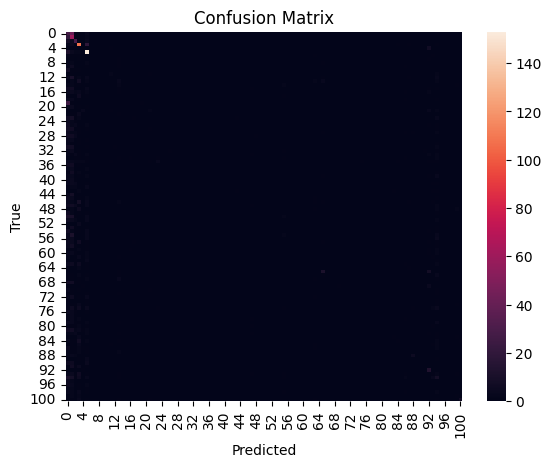

In [ ]:
svc_task('ovr')

## Task5

### Best score use cross-valid test on train set

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for C
param_grid = {'C':  [0.1, 0.5, 1, 5, 10, 50, 100]}

# Create the SVC classifier
svc = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')  # cv=5 for 5-fold cross-validation

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best value of C
best_C = grid_search.best_params_['C']
print("Best value of C:", best_C)

# Get the best accuracy score
best_accuracy = grid_search.best_score_
print("Best accuracy score:", best_accuracy)

Best value of C: 50
Best accuracy score: 0.2918347742555235


### Best score use test set

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the list of C values
C_values = [x for x in range(1, 100)]

best_C = None
best_accuracy = 0

# Iterate through C values
for C in C_values:
    # Create and train the SVC classifier
    svc = SVC(C=C)
    svc.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = svc.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_test)

    # Update best C and accuracy if current C performs better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

# Print the best C and accuracy
print("Best value of C:", best_C)
print("Best accuracy score:", best_accuracy)

Best value of C: 48
Best accuracy score: 0.2828341013824885
